Valor masa estimado con m1 = m2 = 6.00 M_sun (SNR=10006.84)


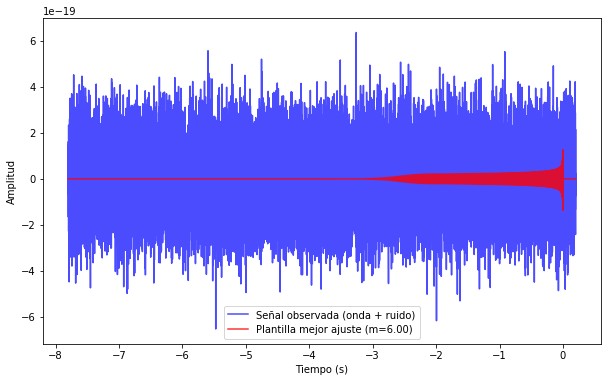

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
from pycbc.types import TimeSeries
from pycbc.psd import aLIGOZeroDetHighPower

# ================================
# 1. Generar la onda "real" (señal observada)
# ================================
hp_rom, hc_rom = get_td_waveform(
    approximant='SEOBNRv4_ROM',
    mass1=6,
    mass2=6,
    delta_t=1.0 / 4096,
    f_lower=40
)

# Convertir a numpy y agregar ruido
t = hp_rom.sample_times
signal = np.array(hp_rom)

# Ruido gaussiano escalado
gaussian_noise = np.random.normal(size=len(t))
scaled_noise = gaussian_noise * np.max(np.abs(signal))

# Señal observada (onda + ruido)
observed_signal = signal + scaled_noise

# Convertir a TimeSeries de PyCBC
observed_ts = TimeSeries(observed_signal, delta_t=1.0/4096)

# ================================
# 2. Preparar PSD (Power Spectral Density)
# ================================
data_fd = observed_ts.to_frequencyseries()
psd = aLIGOZeroDetHighPower(len(data_fd), data_fd.delta_f, 20.0)

# ================================
# 3. Búsqueda de masas por matched filter
# ================================
masses = np.arange(5, 15, 1)   # rango de búsqueda de m1 = m2
best_snr = 0
best_mass = None

for m in masses:
    # generar plantilla
    hp, _ = get_td_waveform(
        approximant='SEOBNRv4_ROM',
        mass1=m,
        mass2=m,
        delta_t=1.0/4096,
        f_lower=40
    )
    
    # Ajustar longitud de la plantilla al dato observado
    hp.resize(len(observed_ts))
    hp_fd = hp.to_frequencyseries()

    # matched filter
    snr = matched_filter(hp_fd, data_fd, psd=psd, low_frequency_cutoff=40.0)

    # buscar el máximo valor de SNR
    peak_snr = abs(snr).numpy().max()
    if peak_snr > best_snr:
        best_snr = peak_snr
        best_mass = m

print("Valor masa estimado con m1 = m2 = {:.2f} M_sun (SNR={:.2f})".format(best_mass, best_snr))

# ================================
# 4. Graficar señal observada vs plantilla óptima
# ================================
hp_best, _ = get_td_waveform(
    approximant='SEOBNRv4_ROM',
    mass1=best_mass,
    mass2=best_mass,
    delta_t=1.0/4096,
    f_lower=40
)
hp_best.resize(len(observed_ts))

plt.figure(figsize=(10,6))
plt.plot(t, observed_signal, label=u"Señal observada (onda + ruido)",color='blue', alpha=0.7)
plt.plot(hp_best.sample_times, hp_best, label=u"Plantilla mejor ajuste (m={:.2f})".format(best_mass),color='red', alpha=0.8)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.legend()
plt.show()


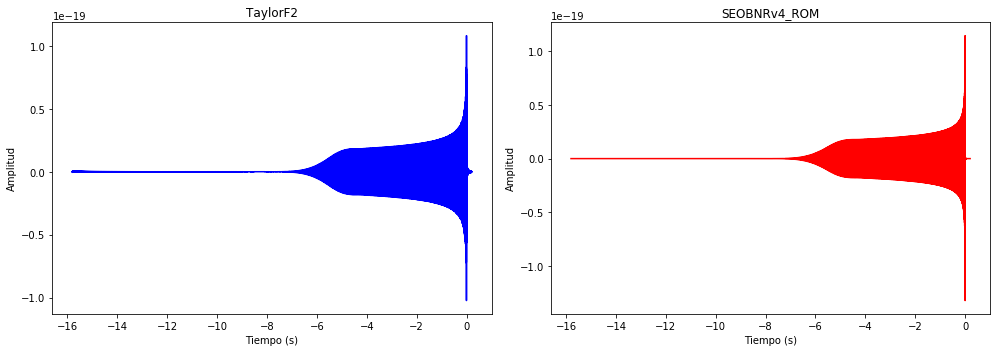

In [7]:
from pycbc.waveform import get_td_waveform
import matplotlib.pyplot as plt

# Parámetros de masa iguales
mass = 6  # en masas solares

# Generar forma de onda TaylorF2
hp1, hc1 = get_td_waveform(approximant="TaylorF2",
                           mass1=mass,
                           mass2=mass,
                           delta_t=1.0/4096,
                           f_lower=30)

# Generar forma de onda SEOBNRv4_ROM
hp2, hc2 = get_td_waveform(approximant="SEOBNRv4_ROM",
                           mass1=mass,
                           mass2=mass,
                           delta_t=1.0/4096,
                           f_lower=30)

# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Primer gráfico: TaylorF2
axes[0].plot(hp1.sample_times, hp1, color='blue')
axes[0].set_title("TaylorF2")
axes[0].set_xlabel("Tiempo (s)")
axes[0].set_ylabel("Amplitud")

# Segundo gráfico: SEOBNRv4_ROM
axes[1].plot(hp2.sample_times, hp2, color='red')
axes[1].set_title("SEOBNRv4_ROM")
axes[1].set_xlabel("Tiempo (s)")
axes[1].set_ylabel("Amplitud")

plt.tight_layout()  # Ajusta espacios automáticamente
plt.show()


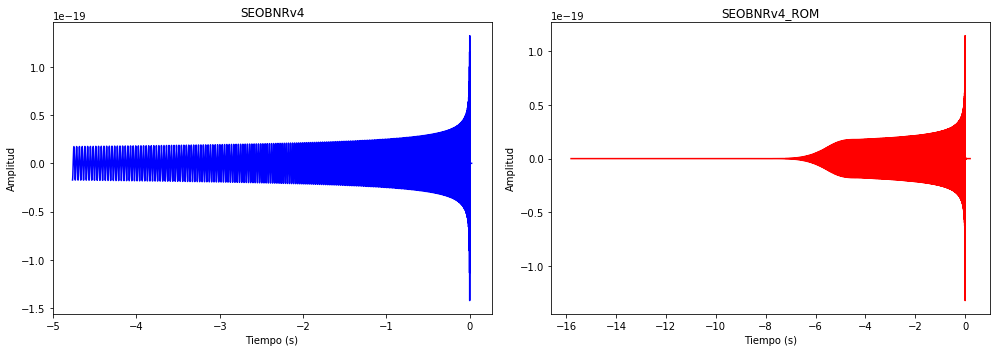

In [8]:
from pycbc.waveform import get_td_waveform
import matplotlib.pyplot as plt

# Parámetros de masa iguales
mass = 6  # en masas solares

# Generar forma de onda TaylorF2
hp1, hc1 = get_td_waveform(approximant="SEOBNRv4",
                           mass1=mass,
                           mass2=mass,
                           delta_t=1.0/4096,
                           f_lower=30)

# Generar forma de onda SEOBNRv4_ROM
hp2, hc2 = get_td_waveform(approximant="SEOBNRv4_ROM",
                           mass1=mass,
                           mass2=mass,
                           delta_t=1.0/4096,
                           f_lower=30)

# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Primer gráfico: TaylorF2
axes[0].plot(hp1.sample_times, hp1, color='blue')
axes[0].set_title("SEOBNRv4")
axes[0].set_xlabel("Tiempo (s)")
axes[0].set_ylabel("Amplitud")

# Segundo gráfico: SEOBNRv4_ROM
axes[1].plot(hp2.sample_times, hp2, color='red')
axes[1].set_title("SEOBNRv4_ROM")
axes[1].set_xlabel("Tiempo (s)")
axes[1].set_ylabel("Amplitud")

plt.tight_layout()  # Ajusta espacios automáticamente
plt.show()


In [9]:
import numpy as np
from pycbc.waveform import get_td_waveform
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.noise.gaussian import noise_from_psd
from pycbc.types import TimeSeries

# --- 1. Generar señal simulada ---
delta_t = 1.0 / 4096
true_mass = 6.0

hp, _ = get_td_waveform(approximant="SEOBNRv4_ROM",
                        mass1=true_mass, mass2=true_mass,
                        delta_t=delta_t, f_lower=40)

# PSD y ruido
psd = aLIGOZeroDetHighPower(len(hp)//2 + 1, 1.0/hp.duration, 20)
noise = noise_from_psd(len(hp), delta_t, psd, seed=123)
noise.start_time = hp.start_time  # igualar epoch
observed = hp + noise

# --- 2. Definir rango de masas ---
masses = np.linspace(5.0, 15.0, 50)  # 50 valores entre 5 y 15 M_sun

best_match = -np.inf
best_mass = None
match_values = []

# --- 3. Evaluar cada masa ---
for m in masses:
    hp_trial, _ = get_td_waveform(approximant="SEOBNRv4_ROM",
                                  mass1=m, mass2=m,
                                  delta_t=delta_t, f_lower=40)
    
    # Ajustar longitud
    min_len = min(len(hp_trial), len(observed))
    hp_trial = hp_trial[:min_len]
    obs = observed[:min_len]
    
    # Inner product (match) normalizado
    match = np.sum(hp_trial.numpy() * obs.numpy())
    match /= np.sqrt(np.sum(hp_trial.numpy()**2) * np.sum(obs.numpy()**2))
    
    match_values.append(match)
    
    if match > best_match:
        best_match = match
        best_mass = m

# --- 4. Estimación de masa y rango aproximado ---
# Rango aproximado: masas con match > 95% del máximo
match_values = np.array(match_values)
mask = match_values > 0.95 * best_match
mass_uncertainty = (masses[mask].max() - masses[mask].min()) / 2.0

print("Masa estimada: {:.2f} ± {:.2f} M_sun".format(best_mass, mass_uncertainty))


Masa estimada: 6.22 ± 0.00 M_sun


Masa estimada: 6.002 ± 0.003 M_sun
Match máximo: 0.9867
Masa ponderada por match: 15.707


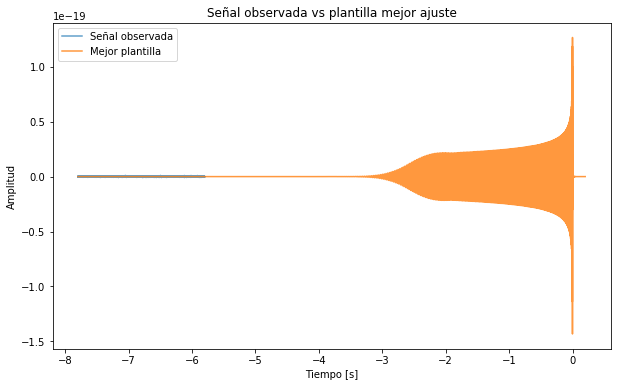

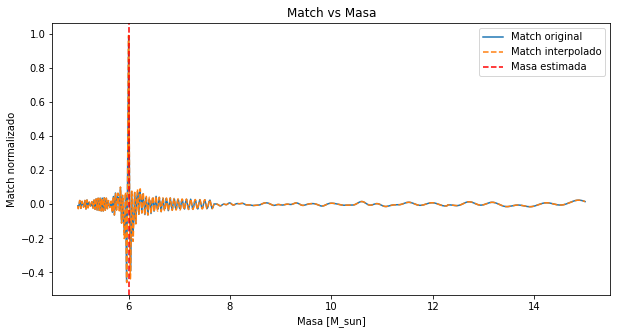

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pycbc.waveform import get_td_waveform
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.noise.gaussian import noise_from_psd
from pycbc.types import TimeSeries

# --- 1. Generar señal simulada ---
delta_t = 1.0 / 4096
true_mass = 6.0  # masa real

hp, _ = get_td_waveform(approximant="SEOBNRv4_ROM",
                        mass1=true_mass, mass2=true_mass,
                        delta_t=delta_t, f_lower=40)

# PSD y ruido
psd = aLIGOZeroDetHighPower(len(hp)//2 + 1, 1.0/hp.duration, 20)
noise = noise_from_psd(len(hp), delta_t, psd, seed=123)
noise.start_time = hp.start_time
observed = hp + noise

# --- 2. Rango de masas ---
masses = np.linspace(5.0, 15.0, 500)
best_match = -np.inf
best_mass = None
match_values = []

# --- 3. Evaluar cada masa ---
for m in masses:
    hp_trial, _ = get_td_waveform(approximant="SEOBNRv4_ROM",
                                  mass1=m, mass2=m,
                                  delta_t=delta_t, f_lower=40)
    
    # Ajustar longitud
    min_len = min(len(hp_trial), len(observed))
    hp_trial = hp_trial[:min_len]
    obs = observed[:min_len]
    
    # Inner product normalizado
    match = np.sum(hp_trial.numpy() * obs.numpy())
    match /= np.sqrt(np.sum(hp_trial.numpy()**2) * np.sum(obs.numpy()**2))
    
    match_values.append(match)
    
    if match > best_match:
        best_match = match
        best_mass = m
        hp_best = hp_trial

match_values = np.array(match_values)

# --- 4. Interpolación para incertidumbre ---
interp_func = interp1d(masses, match_values, kind='cubic')
fine_masses = np.linspace(masses.min(), masses.max(), 5000)
fine_match = interp_func(fine_masses)

# Encontrar rango donde match >= 0.95 * máximo
mask = fine_match >= 0.95 * best_match
mass_uncertainty = (fine_masses[mask].max() - fine_masses[mask].min()) / 2.0

# Masa ponderada por match
mass_weighted = np.sum(masses * match_values) / np.sum(match_values)

# --- 5. Resultados ---
print("Masa estimada: {:.3f} ± {:.3f} M_sun".format(best_mass, mass_uncertainty))
print("Match máximo: {:.4f}".format(best_match))
print("Masa ponderada por match: {:.3f}".format(mass_weighted))


# --- 6. Gráfico señal observada vs plantilla ---
plt.figure(figsize=(10,6))
plt.plot(obs.sample_times, obs, label=u"Señal observada", alpha=0.7)
plt.plot(hp_best.sample_times, hp_best, label=u"Mejor plantilla", alpha=0.8)
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title(u"Señal observada vs plantilla mejor ajuste")
plt.legend()
plt.show()

# --- 7. Gráfico match vs masa ---
plt.figure(figsize=(10,5))
plt.plot(masses, match_values, label=u"Match original")
plt.plot(fine_masses, fine_match, label=u"Match interpolado", linestyle='--')
plt.axvline(best_mass, color='red', linestyle='--', label=u"Masa estimada")
plt.xlabel(u"Masa [M_sun]")
plt.ylabel(u"Match normalizado")
plt.title(u"Match vs Masa")
plt.legend()
plt.show()
